In [1]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from config_reader import config_reader
import scipy
import math

Helper functions to create a model

In [2]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):
     
    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")
    
    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)    
    x = pooling(x, 2, 2, "pool3_1")
    
    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)    
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)    
    
    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)
    
    return x

def stage1_block(x, num_p, branch):
    
    # Block 1        
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)
    
    return x

def stageT_block(x, num_p, stage, branch):
        
    # Block 1        
    x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))
    
    return x

Create keras model and load weights

In [3]:
weights_path = "model.h5" # orginal weights converted from caffe
#weights_path = "training/weights.best.h5" # weights tarined from scratch 

input_shape = (None,None,3)

img_input = Input(shape=input_shape)

stages = 6
np_branch1 = 38
np_branch2 = 19

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)  # [-0.5, 0.5]

# VGG
stage0_out = vgg_block(img_normalized)

# stage 1
stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

# stage t >= 2
for sn in range(2, stages + 1):
    stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
    stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
    if (sn < stages):
        x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])

model = Model(img_input, [stageT_branch1_out, stageT_branch2_out])
model.load_weights(weights_path)

Load a sample image

In [4]:
%matplotlib inline
import cv2
import matplotlib
import pylab as plt
import numpy as np
import util

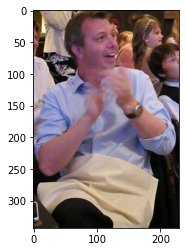

In [5]:
CImagesDir = r'C:\Users\WillyB\Documents\GitHub\embedded_project\Stanford40_JPEGImages\CImages'

test_image = CImagesDir +'/applauding_001.jpg'
oriImg = cv2.imread(test_image) # B,G,R order
plt.imshow(oriImg[:,:,[2,1,0]])

Load configuration

In [6]:
param, model_params = config_reader()

multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]

Show sample heatmaps for right elbow and paf for right wrist and right elbow

In [7]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

'''
# first figure shows padded images
f, axarr = plt.subplots(1, len(multiplier))
f.set_size_inches((20, 5))
# second figure shows heatmaps
f2, axarr2 = plt.subplots(1, len(multiplier))
f2.set_size_inches((20, 5))
# third figure shows PAFs
f3, axarr3 = plt.subplots(2, len(multiplier))
f3.set_size_inches((20, 10))
'''
for m in range(len(multiplier)):
    scale = multiplier[m]
    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.pad_right_down_corner(imageToTest, model_params['stride'], model_params['padValue'])        
    #axarr[m].imshow(imageToTest_padded[:,:,[2,1,0]])
    #axarr[m].set_title('Input image: scale %d' % m)

    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
    #print("Input shape: " + str(input_img.shape))  

    output_blobs = model.predict(input_img)
    #print("Output shape (heatmap): " + str(output_blobs[1].shape))
    
    # extract outputs, resize, and remove padding
    heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
    heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
    paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
    # visualization
    #axarr2[m].imshow(oriImg[:,:,[2,1,0]])
    #ax2 = axarr2[m].imshow(heatmap[:,:,3], alpha=.5) # right elbow
    #axarr2[m].set_title('Heatmaps (Relb): scale %d' % m)
    
    #axarr3.flat[m].imshow(oriImg[:,:,[2,1,0]])
    #ax3x = axarr3.flat[m].imshow(paf[:,:,16], alpha=.5) # right elbow
    #axarr3.flat[m].set_title('PAFs (x comp. of Rwri to Relb): scale %d' % m)
    #axarr3.flat[len(multiplier) + m].imshow(oriImg[:,:,[2,1,0]])
    #ax3y = axarr3.flat[len(multiplier) + m].imshow(paf[:,:,17], alpha=.5) # right wrist
    #axarr3.flat[len(multiplier) + m].set_title('PAFs (y comp. of Relb to Rwri): scale %d' % m)
    
    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    paf_avg = paf_avg + paf / len(multiplier)
    
'''
f2.subplots_adjust(right=0.93)
cbar_ax = f2.add_axes([0.95, 0.15, 0.01, 0.7])
_ = f2.colorbar(ax2, cax=cbar_ax)

f3.subplots_adjust(right=0.93)
cbar_axx = f3.add_axes([0.95, 0.57, 0.01, 0.3])
_ = f3.colorbar(ax3x, cax=cbar_axx)
cbar_axy = f3.add_axes([0.95, 0.15, 0.01, 0.3])
_ = f3.colorbar(ax3y, cax=cbar_axy)
'''

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


'\nf2.subplots_adjust(right=0.93)\ncbar_ax = f2.add_axes([0.95, 0.15, 0.01, 0.7])\n_ = f2.colorbar(ax2, cax=cbar_ax)\n\nf3.subplots_adjust(right=0.93)\ncbar_axx = f3.add_axes([0.95, 0.57, 0.01, 0.3])\n_ = f3.colorbar(ax3x, cax=cbar_axx)\ncbar_axy = f3.add_axes([0.95, 0.15, 0.01, 0.3])\n_ = f3.colorbar(ax3y, cax=cbar_axy)\n'

Heatmap for right knee. Note that the body part is encoded in the 3th channel so in this case right knee is 
at index 9. All body parts are defined in config: 
part_str = [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, pt19]

In [8]:
'''
plt.imshow(oriImg[:,:,[2,1,0]])
plt.imshow(heatmap_avg[:,:,9], alpha=.5)
fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
_ = fig.colorbar(ax2, cax=cbar_ax)
'''

'\nplt.imshow(oriImg[:,:,[2,1,0]])\nplt.imshow(heatmap_avg[:,:,9], alpha=.5)\nfig = matplotlib.pyplot.gcf()\ncax = matplotlib.pyplot.gca()\nfig.set_size_inches(20, 20)\nfig.subplots_adjust(right=0.93)\ncbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])\n_ = fig.colorbar(ax2, cax=cbar_ax)\n'

paf vectors for right elbow and right wrist

In [9]:
'''

from numpy import ma
U = paf_avg[:,:,16] * -1
V = paf_avg[:,:,17]
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)
# 1
plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]], alpha = .5)
s = 5
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)
'''

"\n\nfrom numpy import ma\nU = paf_avg[:,:,16] * -1\nV = paf_avg[:,:,17]\nX, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))\nM = np.zeros(U.shape, dtype='bool')\nM[U**2 + V**2 < 0.5 * 0.5] = True\nU = ma.masked_array(U, mask=M)\nV = ma.masked_array(V, mask=M)\n# 1\nplt.figure()\nplt.imshow(oriImg[:,:,[2,1,0]], alpha = .5)\ns = 5\nQ = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], \n               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')\n\nfig = matplotlib.pyplot.gcf()\nfig.set_size_inches(20, 20)\n"

Visualise all detected body parts. Note that we use peaks in heatmaps

In [10]:
from scipy.ndimage.filters import gaussian_filter
all_peaks = []
peak_counter = 0

for part in range(19-1):
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

In [11]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]

In [12]:
connection_all = []
special_k = []
mid_num = 10

for k in range(len(mapIdx)):
    score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0]-1]
    candB = all_peaks[limbSeq[k][1]-1]
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                # failure case when 2 body parts overlaps
                if norm == 0:
                    continue
                vec = np.divide(vec, norm)
                
                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

In [13]:
# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, 20))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): #1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                print ("found = 2")
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])

In [14]:
# delete some rows of subset which has few parts occur
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

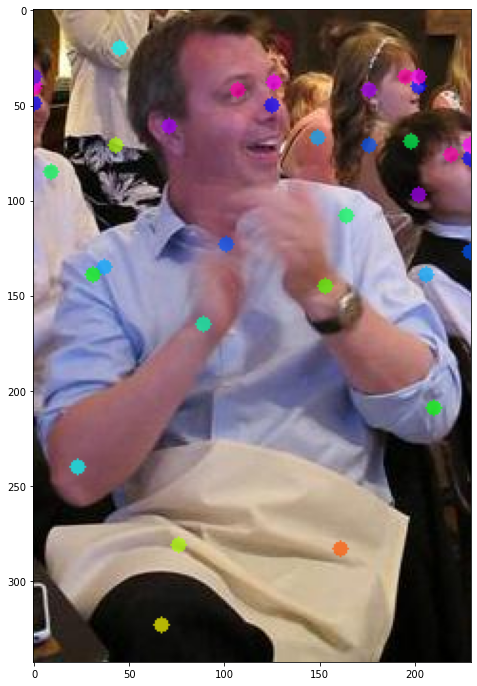

In [15]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv2.imread(test_image) # B,G,R order

for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
    #if not all_peaks[i]:
    #    continue
    #else:
        cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)
    

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

In [16]:
all_peaks

[[(202, 40, 0.8866701275110245, 0),
  (0, 49, 0.46600398421287537, 1),
  (125, 50, 0.783407986164093, 2),
  (229, 78, 0.3107221722602844, 3)],
 [(176, 71, 0.31262904219329357, 4),
  (101, 123, 0.5676034167408943, 5),
  (229, 127, 0.12323100560752209, 6)],
 [(149, 67, 0.4009564146399498, 7),
  (37, 135, 0.5113227143883705, 8),
  (206, 139, 0.3640278950333595, 9)],
 [(45, 20, 0.31643100548535585, 10), (23, 240, 0.5152665954083204, 11)],
 [(89, 165, 0.5031777210533619, 12)],
 [(198, 69, 0.1761897848919034, 13),
  (9, 85, 0.5274195522069931, 14),
  (164, 108, 0.5331787765026093, 15)],
 [(31, 139, 0.2018598672002554, 16), (210, 209, 0.44829984894022346, 17)],
 [(153, 145, 0.47417735354974866, 18)],
 [(43, 71, 0.13464741897769272, 19), (76, 281, 0.183575400384143, 20)],
 [(67, 323, 0.11232859785013716, 21)],
 [],
 [(161, 283, 0.1761135283159092, 22)],
 [],
 [],
 [(195, 35, 0.9172786176204681, 23),
  (0, 41, 0.15638671815395355, 24),
  (107, 42, 0.8450943976640701, 25),
  (219, 76, 0.64302587

In [17]:
subset[0]

array([ 2.        ,  5.        ,  8.        , 11.        , 12.        ,
       15.        , 17.        , 18.        , 20.        , 21.        ,
       -1.        , 22.        , -1.        , -1.        , 25.        ,
       28.        , 32.        , -1.        , 15.58936113, 14.        ])

In [18]:
limbSeq

[[2, 3],
 [2, 6],
 [3, 4],
 [4, 5],
 [6, 7],
 [7, 8],
 [2, 9],
 [9, 10],
 [10, 11],
 [2, 12],
 [12, 13],
 [13, 14],
 [2, 1],
 [1, 15],
 [15, 17],
 [1, 16],
 [16, 18],
 [3, 17],
 [6, 18]]

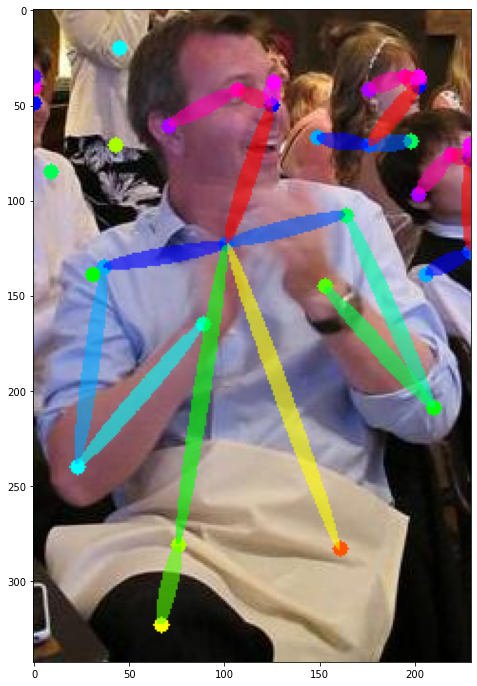

In [19]:
# visualize 2
stickwidth = 4

for i in range(17):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

In [20]:
bestScore = 0
savedIndex = None
for x in range(len(subset)):
    score = subset[x][-2]
    if score > bestScore:
        bestScore = score
        savedIndex = x
bestPersonSubset = subset[savedIndex][:-2]
print(bestScore)
print(bestPersonSubset)


15.589361126174174
[ 2.  5.  8. 11. 12. 15. 17. 18. 20. 21. -1. 22. -1. -1. 25. 28. 32. -1.]


In [21]:
len(bestPersonSubset.astype(int))

18

In [22]:
from itertools import chain
temp = [list(chain.from_iterable(all_peaks))[i] for i in bestPersonSubset.astype(int).tolist()] 
list(temp)
temp[0]

(125, 50, 0.783407986164093, 2)

In [68]:
partCoords = np.zeros((18,2))
partCoords.fill(None)
for i in range(len(bestPersonSubset.astype(int))):
    if bestPersonSubset[i] == -1.:
        print("-1 found on index", i)
        continue
    else:
        partCoords[i][0] = list(chain.from_iterable(all_peaks))[bestPersonSubset.astype(int)[i]][0]
        partCoords[i][1] = list(chain.from_iterable(all_peaks))[bestPersonSubset.astype(int)[i]][1]
partCoords

-1 found on index 10
-1 found on index 12
-1 found on index 13
-1 found on index 17


array([[125.,  50.],
       [101., 123.],
       [ 37., 135.],
       [ 23., 240.],
       [ 89., 165.],
       [164., 108.],
       [210., 209.],
       [153., 145.],
       [ 76., 281.],
       [ 67., 323.],
       [ nan,  nan],
       [161., 283.],
       [ nan,  nan],
       [ nan,  nan],
       [107.,  42.],
       [126.,  38.],
       [ 71.,  61.],
       [ nan,  nan]])

In [76]:
tempCoords =[]
for x in partCoords:
    if math.isnan(x[0]):
        tempCoords.append(tuple(x))
    else:
        tempCoords.append(tuple((int(x[0]),int(x[1]))))

        

In [77]:
tempCoords
#np.save("partCoords.npy", np.array(partCoords))

[(125, 50),
 (101, 123),
 (37, 135),
 (23, 240),
 (89, 165),
 (164, 108),
 (210, 209),
 (153, 145),
 (76, 281),
 (67, 323),
 (nan, nan),
 (161, 283),
 (nan, nan),
 (nan, nan),
 (107, 42),
 (126, 38),
 (71, 61),
 (nan, nan)]

In [78]:
int(partCoords[0][0])

125

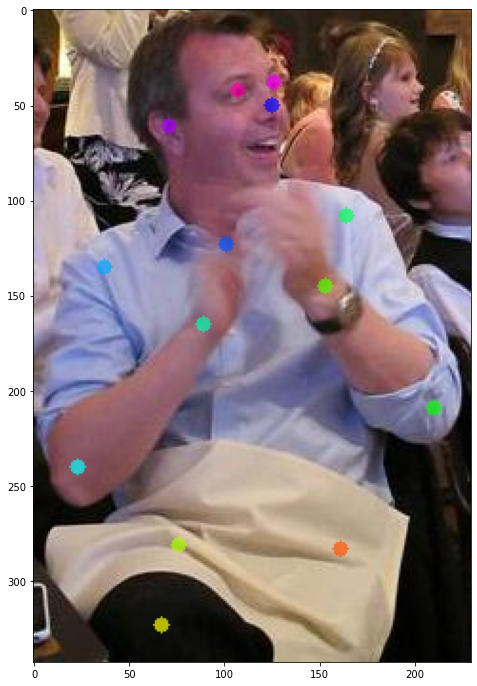

In [85]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')


canvas = cv2.imread(test_image) # B,G,R order

for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    if math.isnan(tempCoords[i][0]):
        continue
    else:
        cv2.circle(canvas, tempCoords[i][0:2], 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

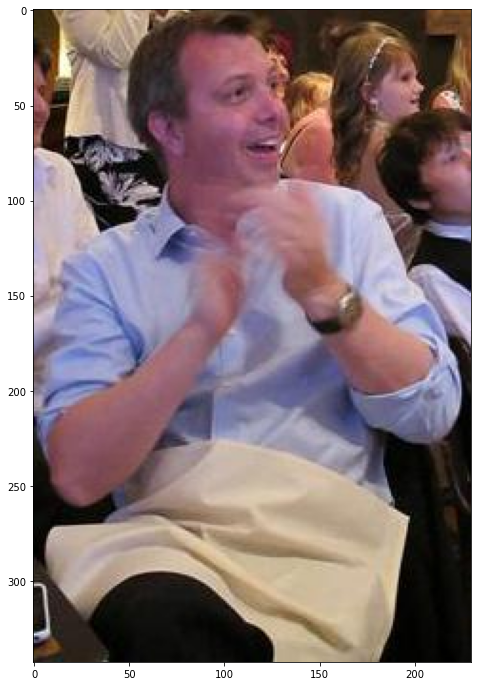

In [86]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')


canvas = cv2.imread(test_image) # B,G,R order

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)